In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import layers, models
from PIL import Image
from datetime import datetime
import tqdm
import matplotlib.pyplot as plt
# import cv2
import pickle
import re, math
import shutil
import random
import tensorflow_addons as tfa
from PIL import Image, ImageDraw, ImageFont
import pandas as pd

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.get_logger().setLevel('ERROR')

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
from transformers import CLIPProcessor, TFCLIPModel, CLIPTokenizer
from transformers import AutoProcessor, TFCLIPModel, TFCLIPVisionModel

# Load the CLIP model and processor
model_name = "openai/clip-vit-large-patch14"
clip_model = TFCLIPModel.from_pretrained(model_name)
processor = AutoProcessor.from_pretrained(model_name)
tokenizer = CLIPTokenizer.from_pretrained(model_name)
clip_vision_model = TFCLIPVisionModel.from_pretrained(model_name)

All PyTorch model weights were used when initializing TFCLIPModel.

All the weights of TFCLIPModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCLIPVisionModel: ['text_model.encoder.layers.0.layer_norm1.weight', 'text_model.encoder.layers.4.self_attn.out_proj.weight', 'text_model.encoder.layers.6.self_attn.k_proj.bias', 'text_model.encoder.layers.10.mlp.fc2.bias', 'text_model.encoder.layers.1.self_attn.out_proj.weight', 'text_model.encoder.layers.4.self_attn.out_proj.bias', 'text_model.encoder.layers.10.mlp.fc2.weight', 'text_model.encoder.layers.2.layer_norm2.weight', 'text_model.encoder.layers.7.layer_norm2.bias', 'text_model.encoder.layers.4.mlp.fc2.weight', 'text_model.encoder.layers.3.self_attn.out_proj.bias', 'text_model.encoder.layers.2.mlp.fc1.wei

## Set up dataset

In [4]:
# File paths
caption_file_path = "/home/henry/HD/DL/DL_comp3/2024-datalab-cup3-reverse-image-caption/dataset/text2ImgData.pkl"
id2word_file_path = "/home/henry/HD/DL/DL_comp3/2024-datalab-cup3-reverse-image-caption/dictionary/id2Word.npy"

# Load the .pkl file
with open(caption_file_path, 'rb') as file:
    captions_data = pickle.load(file)

# Convert to DataFrame
captions_df = pd.DataFrame(captions_data)

# Load the id2Word mapping
data = np.load(id2word_file_path)

# Convert array to dictionary
id2word = {int(row[0]): row[1] for row in data}


In [5]:
# # Batch size for processing
# BATCH_SIZE = 1024  # Adjust based on your GPU memory

# # Prepare captions
# all_captions = []
# all_image_paths = []

# for index, row in tqdm.tqdm(captions_df.iterrows(), total=captions_df.shape[0], desc="Preparing captions"):
#     image_path = row['ImagePath']
#     captions = row['Captions']
#     all_image_paths.extend([image_path] * len(captions))
#     all_captions.extend(captions)

# # Function to process text embeddings
# def batch_text_embeddings(captions_batch):
#     texts = [" ".join([id2word.get(int(word_id), "<UNK>") for word_id in caption]) for caption in captions_batch]
#     texts = [text.replace(" <PAD>", "") for text in texts]
#     text_inputs = tokenizer(texts, return_tensors="tf", padding=True, truncation=True)
#     text_embeddings = clip_model.get_text_features(input_ids=text_inputs["input_ids"])
#     # text_embeddings = tf.nn.l2_normalize(text_embeddings, axis=-1)
#     return texts, text_embeddings

# # Batched processing
# image_text_pairs = []
# for i in tqdm.tqdm(range(0, len(all_captions), BATCH_SIZE), desc="Processing batches"):
#     batch_captions = all_captions[i:i + BATCH_SIZE]
#     batch_image_paths = all_image_paths[i:i + BATCH_SIZE]
#     texts, batch_embeddings = batch_text_embeddings(batch_captions)
#     image_text_pairs.extend(zip(batch_image_paths, texts, batch_embeddings.numpy()))

# # Create TensorFlow Dataset
# dataset = tf.data.Dataset.from_generator(
#     lambda: iter(image_text_pairs),
#     output_signature=(
#         tf.TensorSpec(shape=(), dtype=tf.string),  # Image path
#         tf.TensorSpec(shape=(), dtype=tf.string),  # Text
#         tf.TensorSpec(shape=(512,), dtype=tf.float32)  # Text embeddings
#     )
# )

# # Preview the dataset
# for image_path, text, text_embedding in dataset.take(2):
#     print("Image Path:", image_path.numpy().decode())
#     print("Text Embedding Shape:", text_embedding.shape)
#     print("Text:", text.numpy())

In [6]:
# output_file = "/home/henry/HD/DL/DL_comp3/2024-datalab-cup3-reverse-image-caption/image_text_pairs.pkl"

# with open(output_file, "wb") as f:
#     pickle.dump(image_text_pairs, f)

# print(f"Image-text pairs saved to {output_file}")

### Load from pkl

In [7]:
import pickle
import tensorflow as tf

# Path to the stored file
input_file = "/home/henry/HD/DL/DL_comp3/2024-datalab-cup3-reverse-image-caption/aug_image_text_pairs_large.pkl"

# Load the image-text pairs
with open(input_file, "rb") as f:
    image_text_pairs = pickle.load(f)

print(f"Loaded {len(image_text_pairs)} image-text pairs.")

# Create a TensorFlow Dataset from the loaded data
dataset = tf.data.Dataset.from_generator(
    lambda: iter(image_text_pairs),
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),  # Image path
        tf.TensorSpec(shape=(), dtype=tf.string),  # Text
        tf.TensorSpec(shape=(768,), dtype=tf.float32)  # Text embeddings
    )
)

# Preview the dataset
for image_path, text, text_embedding in dataset.take(3):
    print("Image Path:", image_path.numpy().decode())
    print("Text Embedding Shape:", text_embedding.shape)
    print("Text:", text.numpy())


Loaded 139319 image-text pairs.
Image Path: ./102flowers/image_06734.jpg
Text Embedding Shape: (768,)
Text: b'the petals of the flower are pink in color and have a yellow center'
Image Path: ./102flowers/image_06734.jpg
Text Embedding Shape: (768,)
Text: b'the petals of the flower are pink and yellow in the center'
Image Path: ./102flowers/image_06734.jpg
Text Embedding Shape: (768,)
Text: b'this flower is pink and white in color with petals that are multi colored'


In [8]:
# Feel free to change these parameters according to your system's configuration
# data
dataset_name = "oxford_flowers102"
dataset_repetitions = 1
num_epochs = 60
image_size = 64
suffle_times = 10

# KID = Kernel Inception Distance, see related section
kid_image_size = 75
kid_diffusion_steps = 20
plot_diffusion_steps = 20

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 128, 256]
block_depth = 2

# optimization
batch_size = 96
ema = 0.999
learning_rate = 2e-4
weight_decay = 1e-4

In [9]:
from sklearn.model_selection import train_test_split

# Train-validation split
train_pairs, val_pairs = train_test_split(image_text_pairs, test_size=0.05, random_state=42)

# Convert to TensorFlow datasets
def create_dataset(pairs):
    return tf.data.Dataset.from_generator(
        lambda: iter(pairs),
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),  # Image path
            tf.TensorSpec(shape=(), dtype=tf.string),  #
            tf.TensorSpec(shape=(768,), dtype=tf.float32)   # Caption
        )
    )

train_dataset = create_dataset(train_pairs)
val_dataset = create_dataset(val_pairs)

# Preprocess function with augmentation for training
def preprocess_image_with_augmentation(image_path, caption, text_embedding):
    # Load and preprocess image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [image_size, image_size]) / 255.0  # Resize and normalize

    # Data augmentation
    # image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    # image = tf.image.random_flip_up_down(image)  # Random vertical flip
    # image = tf.image.random_brightness(image, max_delta=0.1)  # Random brightness

    return image, caption, text_embedding

# Preprocess function for validation (no augmentation)
def preprocess_image_without_augmentation(image_path, caption, text_embedding):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [image_size, image_size]) / 255.0  # Resize and normalize
    return image, caption, text_embedding

# Apply preprocessing
train_dataset = (
    train_dataset
    .map(preprocess_image_with_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(buffer_size=256)
    .batch(batch_size, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    val_dataset
    .map(preprocess_image_without_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(buffer_size=256)
    .batch(batch_size, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

# Preview the training dataset
for images, captions, text_embedding in train_dataset.take(1):
    print("Image Batch Shape:", images.shape)
    print("Caption Batch:", captions)
    print("Text Embedding Shape:", text_embedding.shape)


Image Batch Shape: (96, 64, 64, 3)
Caption Batch: tf.Tensor(
[b'this flower with dense pointed petals come is a light peach color'
 b'phallic like flower with red orange and yellow petals that are tall and droop at the very top'
 b'this flower has red petals with many layers and yellow stamen'
 b'the green pedal and toothed pedal of this dark blue and white flower are described by a series of teeth'
 b'the flowers are yello leaflike and have green pedicels on each side'
 b'this flower has a tall yellow pistil inside the center of a purple bell shaped blossom'
 b'the flower has a few small round petals that are red in color'
 b'this flower has pink and white petals that have yellow stamen'
 b'the flower has pink petals with a dark green pedicel'
 b'this flower has thick purple petals and long stamens'
 b'the petals of this flower are mottled and have yellow stamen'
 b'this flower is pink and yellow in color with petals that are spotted'
 b'the flower has small round petals that are deep

### Toy dataset

In [10]:
# Create a toy training dataset with the first 2 batches
toy_train_dataset = (
    train_dataset.take(2)  # Take the first 2 batches
)

# Preview the toy dataset
for images, captions, text_embedding in toy_train_dataset:
    print("Image Batch Shape:", images.shape)
    print("Caption Batch Shape:", captions.shape)
    print("Text Embedding Shape:", text_embedding.shape)


Image Batch Shape: (96, 64, 64, 3)
Caption Batch Shape: (96,)
Text Embedding Shape: (96, 768)
Image Batch Shape: (96, 64, 64, 3)
Caption Batch Shape: (96,)
Text Embedding Shape: (96, 768)


# Model

In [11]:
class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        # Use TensorFlow functions instead of ops
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype="float32")
        return (tf.matmul(features_1, tf.transpose(features_2)) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(generated_features, generated_features)
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype="float32")
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(kernel_generated * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()

In [12]:
def sinusoidal_embedding(x, embedding_dims, embedding_max_frequency=1000.0):
    embedding_min_frequency = 1.0
    frequencies = tf.math.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2
        )
    )
    angular_speeds = tf.cast(2.0 * math.pi * frequencies, "float32")
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=-1
    )
    return embeddings  # Shape: (batch_size, 1, 1, embedding_dims)



def ResidualBlock(width, context=None):
    def apply(x):
        residual = x
        # Adjust residual channels if necessary
        if residual.shape[-1] != width:
            residual = layers.Conv2D(width, kernel_size=1, padding='same')(residual)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Activation('swish')(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        if context is not None:
            x = CrossAttention(embed_dim=width)(x, context)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Activation('swish')(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply

class CrossAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=4, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads
        )
        self.context_proj = layers.Dense(embed_dim)
        #self.layer_norm = layers.LayerNormalization()

    def call(self, x, context):
        # x: (batch_size, height, width, channels)
        batch_size = tf.shape(x)[0]
        height = tf.shape(x)[1]
        width = tf.shape(x)[2]
        channels = x.shape[-1]
        x_reshaped = tf.reshape(x, (batch_size, height * width, channels))
        
        # Project context to match embed_dim
        #context_proj = self.context_proj(context)  # (batch_size, embed_dim)
        context_proj = context
        context_proj = tf.expand_dims(context_proj, axis=1)  # (batch_size, 1, embed_dim)
        
        # Apply multi-head attention
        attention_output = self.attention(
            query=x_reshaped, key=context_proj, value=context_proj
        )
        #attention_output = self.layer_norm(attention_output)
        
        # Reshape back to (batch_size, height, width, channels)
        attention_output = tf.reshape(attention_output, (batch_size, height, width, channels))
        return attention_output
    
    def get_config(self):
        """Serialization method to save and reload the layer."""
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
        })
        return config


def get_conditional_network(image_size, widths, block_depth, text_embedding_dim, embedding_dims=32):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))
    text_conditions = keras.Input(shape=(text_embedding_dim,))  # CLIP embeddings

    # Sinusoidal embedding for noise variances
    e = layers.Lambda(lambda nv: sinusoidal_embedding(nv, embedding_dims))(noise_variances)
    # Broadcast to match image dimensions
    e = tf.tile(e, [1, image_size, image_size, 1])

    # Initial processing
    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    # Encoder
    for width in widths[:-1]:
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
        skips.append(x)
        x = layers.AveragePooling2D()(x)

    # Bottleneck
    for _ in range(block_depth):
        x = ResidualBlock(widths[-1], context=text_conditions)(x)

    # Decoder
    for width in reversed(widths[:-1]):
        x = layers.UpSampling2D()(x)
        x = layers.Concatenate()([x, skips.pop()])
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)

    # Output layer
    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model(
        inputs=[noisy_images, noise_variances, text_conditions],
        outputs=x,
        name="conditional_residual_unet",
    )


In [13]:
class ConditionalDiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth, text_embedding_dim):
        super().__init__()
        
        self.text_embedding_dim = text_embedding_dim
        self.normalizer = layers.Normalization(axis=-1)
        self.network = get_conditional_network(image_size, widths, block_depth, text_embedding_dim)
        self.ema_network = keras.models.clone_model(self.network)

        self.null_condition = self.get_null_text_embedding()

    def compile(self, **kwargs):
        super().compile(**kwargs)
        
        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(name="kid")
    
    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def get_null_text_embedding(self):
        null_text = ""
        text_inputs = tokenizer(null_text, return_tensors="tf", padding=True, truncation=True)
        text_embedding = clip_model.get_text_features(input_ids=text_inputs["input_ids"])
        text_embedding = tf.nn.l2_normalize(text_embedding, axis=-1)
        return text_embedding

    def denormalize(self, images):
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)
        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)
        signal_rates = tf.cos(diffusion_angles) # α開根號
        noise_rates = tf.sin(diffusion_angles) # (1-α)開根號
        return noise_rates, signal_rates

    # def denoise(self, noisy_images, noise_rates, signal_rates, conditions, training, guidance_scale=1.0):
    #     model = self.network if training else self.ema_network

    #     # Predict noise with conditional inputs
    #     pred_noises_cond = model([noisy_images, noise_rates ** 2, conditions], training=training)

    #     # Predict noise with unconditional inputs (null conditions)
    #     null_conditions = tf.tile(self.null_condition, [tf.shape(conditions)[0], 1])
    #     pred_noises_uncond = model([noisy_images, noise_rates ** 2, null_conditions], training=training)

    #     # Apply classifier-free guidance
    #     pred_noises = pred_noises_uncond + guidance_scale * (pred_noises_cond - pred_noises_uncond)
    #     pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
    #     return pred_noises, pred_images
    
    def denoise(self, noisy_images, noise_rates, signal_rates, conditions, training, puncond=0.2, guidance_scale=1.0):
        # Select the appropriate model (network or ema_network based on training status)
        model = self.network if training else self.ema_network
        null_conditions = tf.tile(self.null_condition, [tf.shape(conditions)[0], 1])

        # During training, we may discard the conditioning (unconditioned prediction with probability puncond)
        if training:
            # With probability puncond, we discard the conditioning, otherwise, we use it
            conditioned = conditions if np.random.rand() > puncond else null_conditions
            
            # Predict noise conditioned on noisy image (and possibly no conditioning)
            pred_noises = model([noisy_images, noise_rates ** 2, conditioned], training=training)
        else:
            # Inference phase: Apply classifier-free guidance
            # 1. Predict the noise without any conditioning (unconditioned prediction)
            pred_noises_uncond = model([noisy_images, noise_rates ** 2, null_conditions], training=training)  # No conditioning
            # 2. Predict the noise conditioned on the given conditions
            pred_noises_cond = model([noisy_images, noise_rates ** 2, conditions], training=training)
            # 3. Apply classifier-free guidance by blending the unconditioned and conditioned predictions
            pred_noises = pred_noises_uncond + guidance_scale * (pred_noises_cond - pred_noises_uncond)
        
        # Compute the denoised image based on the predicted noise
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        
        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps, conditions, guidance_scale=1.0):
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps
        next_noisy_images = initial_noise
        # 接著一步一步去噪
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(noisy_images, noise_rates, signal_rates, conditions, training=False, guidance_scale=guidance_scale)
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(next_diffusion_times)
            next_noisy_images = (next_signal_rates * pred_images + next_noise_rates * pred_noises)
        return pred_images

    def generate(self, num_images, diffusion_steps, conditions, guidance_scale=1.0):
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 3))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps, conditions, guidance_scale=guidance_scale)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, data):
        images, text, text_embedding = data

        images = tf.image.random_flip_left_right(images)  # Random horizontal flip
        #images = tf.image.random_brightness(images, max_delta=0.1)

        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))
        
        # Generate class embeddings for conditions
        conditions = text_embedding

        diffusion_times = tf.random.uniform(shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0)
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, conditions, training=True
            )

            noise_loss = self.loss(noises, pred_noises)
            image_loss = self.loss(images, pred_images)

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, data):
        images, text, text_embedding = data


        # input_ids = ['flower'] * images.shape[0]
        # tokenized_inputs = tokenizer(
        #     input_ids,
        #     padding=True,
        #     truncation=True,
        #     return_tensors="tf"  # Tokenizer handles padding/truncation and outputs tensors
        # )
        # labels = clip_model.get_text_features(input_ids = tokenized_inputs)
        # labels = tf.nn.l2_normalize(labels, axis=-1)

        images = self.normalizer(images, training=False)

        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))
        conditions = text_embedding

        diffusion_times = tf.random.uniform(shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0)
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises

        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, conditions, training=False #Modify
        )
        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        images = self.denormalize(images)
        generated_images = self.generate(batch_size, kid_diffusion_steps, conditions) 
        self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}
    
    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6, val_dataset=val_dataset):
        # Randomly select a batch from the validation dataset
        for val_images, val_labels, val_text_embedding in val_dataset.take(1):
            conditions = val_text_embedding  # Use the labels from the validation set as conditions
            break  # Take only the first batch

        # Select a random subset of conditions
        num_images = num_rows * num_cols
        indices = tf.random.shuffle(tf.range(tf.shape(conditions)[0]))[:num_images]
        random_conditions = tf.gather(conditions, indices)


        
        # Generate images using the random conditions
        generated_images = self.generate(
            num_images=num_images,
            diffusion_steps=plot_diffusion_steps,
            conditions=random_conditions,
        )


        # Plot the generated images
        plt.figure(figsize=(num_cols, num_rows))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()


    def plot_and_save_images_with_captions(self, epoch=None, logs=None, num_rows=3, num_cols=2, val_dataset=val_dataset, save_dir="generated_images0"):
        # Create the directory to save images if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)
        
        # Randomly select a batch from the validation dataset
        for val_images, val_labels, val_text_embedding in val_dataset.take(1):
            conditions = val_text_embedding  # Use the labels from the validation set as conditions
            break  # Take only the first batch

        # Select a random subset of conditions
        num_images = num_rows * num_cols
        indices = tf.random.shuffle(tf.range(tf.shape(conditions)[0]))[:num_images]
        random_conditions = tf.gather(conditions, indices)
        random_labels = tf.gather(val_labels, indices)

        # Generate images using the random conditions
        generated_images = self.generate(
            num_images=num_images,
            diffusion_steps=plot_diffusion_steps,
            conditions=random_conditions,
        )

        # Plot the generated images with captions and save as a single image
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 15))
        axes = axes.flatten()
        for i, ax in enumerate(axes):
            if i < num_images:
                img = (generated_images[i].numpy() * 255).astype('uint8')  # Convert image to uint8
                ax.imshow(img)
                label = random_labels[i].numpy().decode('utf-8')  # Decode the label assuming it's a string tensor
                ax.set_title(label, fontsize=10)
            ax.axis("off")


        # Save the figure with captions
        epoch_str = f"epoch_{epoch}" if epoch is not None else "epoch_unknown"
        output_file = os.path.join(save_dir, f"generated_images_with_captions_{epoch_str}.png")
        plt.savefig(output_file, bbox_inches="tight")
        plt.close()

        print(f"Image with captions saved as {output_file}")

In [14]:
model = ConditionalDiffusionModel(image_size, widths, block_depth, 768)

model.compile(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
# pixelwise mean absolute error is used as loss

In [15]:
# save the best model based on the validation KID metric
checkpoint_path = "checkpoints/DDIM/tf_checkpoint{epoch:03d}"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    #monitor="val_kid",
    #mode="min",
    #save_best_only=True,
    save_freq = int(10*len(list(train_dataset))),  # Save every 10 epochs
    verbose=1
)

In [16]:
# calculate mean and variance of training dataset for normalization
# model.normalizer.adapt(train_dataset)
batched_dataset = train_dataset.map(lambda x, y, z: x).prefetch(tf.data.AUTOTUNE)

# Adapt the normalization layer using the batched dataset
model.normalizer.adapt(batched_dataset)


# try:
#     model.load_weights(checkpoint_path)
#     print("Checkpoint loaded successfully!")
# except Exception as e:
#     print(f"Failed to load checkpoint: {e}")

Epoch 1/60
1378/1378 [==============================] - 347s 248ms/step - n_loss: 0.2444 - i_loss: 0.4716 - val_n_loss: 0.6716 - val_i_loss: 1.9534 - val_kid: 1.8158
Epoch 2/60
1378/1378 [==============================] - 321s 233ms/step - n_loss: 0.1947 - i_loss: 0.3080 - val_n_loss: 0.3568 - val_i_loss: 0.8786 - val_kid: 1.3664
Epoch 3/60
1378/1378 [==============================] - 320s 232ms/step - n_loss: 0.1889 - i_loss: 0.2951 - val_n_loss: 0.2264 - val_i_loss: 0.4282 - val_kid: 1.1230
Epoch 4/60
1378/1378 [==============================] - 320s 232ms/step - n_loss: 0.1854 - i_loss: 0.2887 - val_n_loss: 0.1931 - val_i_loss: 0.3108 - val_kid: 0.7294
Epoch 5/60
1378/1378 [==============================] - 320s 232ms/step - n_loss: 0.1827 - i_loss: 0.2837 - val_n_loss: 0.1846 - val_i_loss: 0.2860 - val_kid: 0.6147
Epoch 6/60
1378/1378 [==============================] - 320s 232ms/step - n_loss: 0.1807 - i_loss: 0.2827 - val_n_loss: 0.1803 - val_i_loss: 0.2829 - val_kid: 0.5320
Epoc

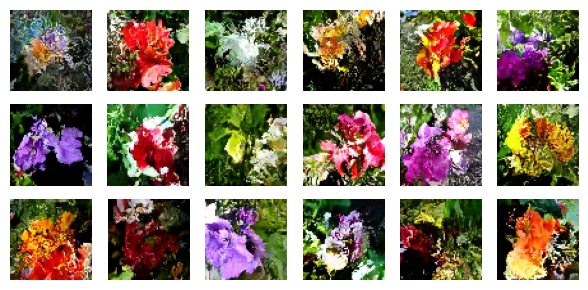

Image with captions saved as generated_images0/generated_images_with_captions_epoch_9.png
Epoch 11/60
1378/1378 [==============================] - 320s 232ms/step - n_loss: 0.1767 - i_loss: 0.2769 - val_n_loss: 0.1756 - val_i_loss: 0.2741 - val_kid: 0.4920
Epoch 12/60
1378/1378 [==============================] - 320s 233ms/step - n_loss: 0.1760 - i_loss: 0.2763 - val_n_loss: 0.1764 - val_i_loss: 0.2722 - val_kid: 0.4727
Epoch 13/60
1378/1378 [==============================] - 321s 233ms/step - n_loss: 0.1756 - i_loss: 0.2767 - val_n_loss: 0.1733 - val_i_loss: 0.2748 - val_kid: 0.4669
Epoch 14/60
1378/1378 [==============================] - 320s 232ms/step - n_loss: 0.1754 - i_loss: 0.2762 - val_n_loss: 0.1730 - val_i_loss: 0.2743 - val_kid: 0.4446
Epoch 15/60
1378/1378 [==============================] - 320s 232ms/step - n_loss: 0.1751 - i_loss: 0.2759 - val_n_loss: 0.1727 - val_i_loss: 0.2714 - val_kid: 0.4192
Epoch 16/60
1378/1378 [==============================] - 320s 233ms/step - 

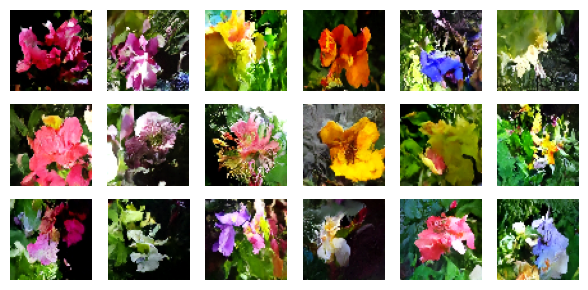

Image with captions saved as generated_images0/generated_images_with_captions_epoch_19.png
Epoch 21/60
1378/1378 [==============================] - 320s 232ms/step - n_loss: 0.1739 - i_loss: 0.2745 - val_n_loss: 0.1716 - val_i_loss: 0.2643 - val_kid: 0.2429
Epoch 22/60
1378/1378 [==============================] - 320s 232ms/step - n_loss: 0.1734 - i_loss: 0.2747 - val_n_loss: 0.1726 - val_i_loss: 0.2621 - val_kid: 0.2318
Epoch 23/60
1378/1378 [==============================] - 320s 233ms/step - n_loss: 0.1736 - i_loss: 0.2744 - val_n_loss: 0.1717 - val_i_loss: 0.2632 - val_kid: 0.2295
Epoch 24/60
1378/1378 [==============================] - 320s 233ms/step - n_loss: 0.1737 - i_loss: 0.2737 - val_n_loss: 0.1730 - val_i_loss: 0.2611 - val_kid: 0.2167
Epoch 25/60
1378/1378 [==============================] - 320s 232ms/step - n_loss: 0.1735 - i_loss: 0.2740 - val_n_loss: 0.1723 - val_i_loss: 0.2612 - val_kid: 0.2124
Epoch 26/60
1378/1378 [==============================] - 320s 232ms/step -

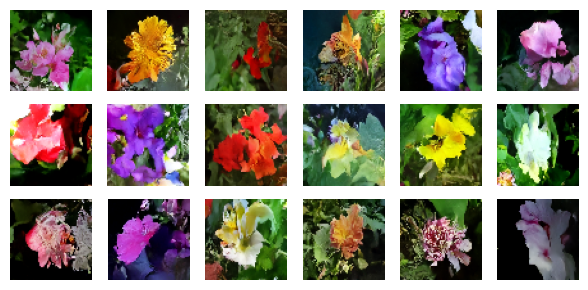

Image with captions saved as generated_images0/generated_images_with_captions_epoch_29.png
Epoch 31/60
1378/1378 [==============================] - 321s 233ms/step - n_loss: 0.1728 - i_loss: 0.2738 - val_n_loss: 0.1695 - val_i_loss: 0.2634 - val_kid: 0.1805
Epoch 32/60
1378/1378 [==============================] - 321s 233ms/step - n_loss: 0.1728 - i_loss: 0.2734 - val_n_loss: 0.1702 - val_i_loss: 0.2618 - val_kid: 0.1666
Epoch 33/60
1378/1378 [==============================] - 321s 233ms/step - n_loss: 0.1729 - i_loss: 0.2736 - val_n_loss: 0.1676 - val_i_loss: 0.2649 - val_kid: 0.1715
Epoch 34/60
1378/1378 [==============================] - 321s 233ms/step - n_loss: 0.1728 - i_loss: 0.2727 - val_n_loss: 0.1705 - val_i_loss: 0.2603 - val_kid: 0.1714
Epoch 35/60
1378/1378 [==============================] - 320s 233ms/step - n_loss: 0.1728 - i_loss: 0.2731 - val_n_loss: 0.1689 - val_i_loss: 0.2604 - val_kid: 0.1711
Epoch 36/60
1378/1378 [==============================] - 320s 232ms/step -

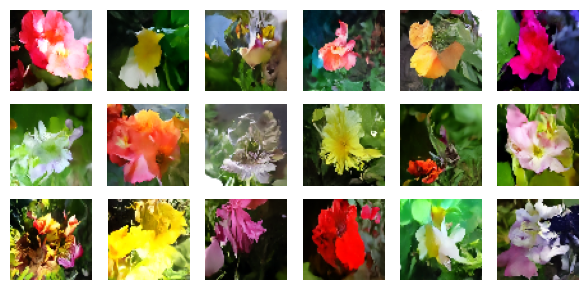

Image with captions saved as generated_images0/generated_images_with_captions_epoch_39.png
Epoch 41/60
1378/1378 [==============================] - 320s 232ms/step - n_loss: 0.1722 - i_loss: 0.2726 - val_n_loss: 0.1682 - val_i_loss: 0.2623 - val_kid: 0.1657
Epoch 42/60
1378/1378 [==============================] - 320s 232ms/step - n_loss: 0.1727 - i_loss: 0.2720 - val_n_loss: 0.1686 - val_i_loss: 0.2633 - val_kid: 0.1656
Epoch 43/60
1378/1378 [==============================] - 320s 232ms/step - n_loss: 0.1724 - i_loss: 0.2729 - val_n_loss: 0.1686 - val_i_loss: 0.2625 - val_kid: 0.1688
Epoch 44/60
1378/1378 [==============================] - 320s 233ms/step - n_loss: 0.1722 - i_loss: 0.2728 - val_n_loss: 0.1699 - val_i_loss: 0.2593 - val_kid: 0.1645
Epoch 45/60
1378/1378 [==============================] - 320s 232ms/step - n_loss: 0.1723 - i_loss: 0.2727 - val_n_loss: 0.1692 - val_i_loss: 0.2617 - val_kid: 0.1721
Epoch 46/60
1378/1378 [==============================] - 320s 232ms/step -

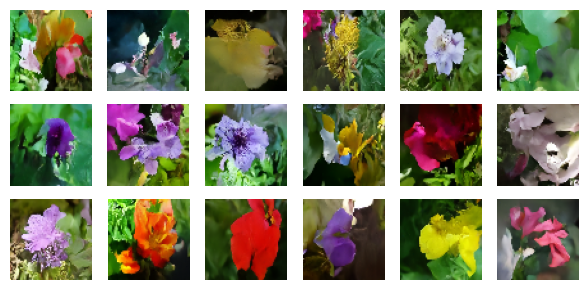

Image with captions saved as generated_images0/generated_images_with_captions_epoch_49.png
Epoch 51/60
1378/1378 [==============================] - 320s 232ms/step - n_loss: 0.1721 - i_loss: 0.2722 - val_n_loss: 0.1687 - val_i_loss: 0.2608 - val_kid: 0.1665
Epoch 52/60
1378/1378 [==============================] - 320s 232ms/step - n_loss: 0.1723 - i_loss: 0.2719 - val_n_loss: 0.1706 - val_i_loss: 0.2577 - val_kid: 0.1697
Epoch 53/60
1378/1378 [==============================] - 320s 232ms/step - n_loss: 0.1722 - i_loss: 0.2721 - val_n_loss: 0.1679 - val_i_loss: 0.2617 - val_kid: 0.1704
Epoch 54/60
1378/1378 [==============================] - 320s 232ms/step - n_loss: 0.1719 - i_loss: 0.2726 - val_n_loss: 0.1693 - val_i_loss: 0.2586 - val_kid: 0.1702
Epoch 55/60
1378/1378 [==============================] - 320s 232ms/step - n_loss: 0.1719 - i_loss: 0.2720 - val_n_loss: 0.1696 - val_i_loss: 0.2604 - val_kid: 0.1754
Epoch 56/60
1378/1378 [==============================] - 320s 232ms/step -

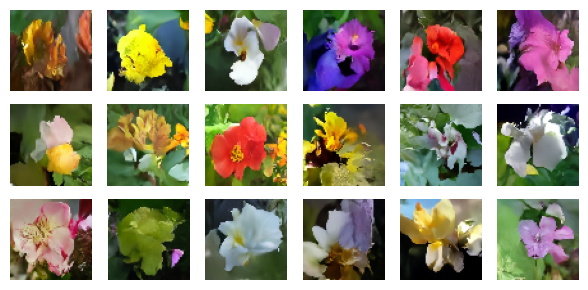

Image with captions saved as generated_images0/generated_images_with_captions_epoch_59.png


In [17]:
def plot_images_every_n_epochs(epoch, logs):
    # Only plot images if the epoch is a multiple of 5
    if (epoch + 1) % 10 == 0:
        model.plot_images(epoch=epoch, logs=logs, val_dataset=val_dataset)
    if (epoch + 1) % 10 == 0:
        model.plot_and_save_images_with_captions(epoch=epoch, logs=logs, val_dataset=val_dataset)

# run training and plot generated images periodically
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=num_epochs,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=plot_images_every_n_epochs),
        # keras.callbacks.LambdaCallback(on_epoch_start=model.plot_images(val_dataset=val_dataset) ),
        checkpoint_callback,
    ],
)

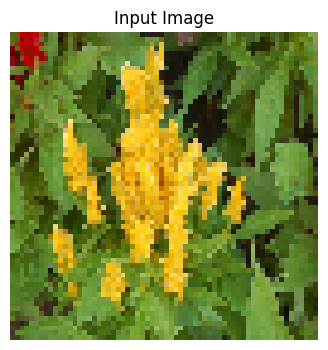

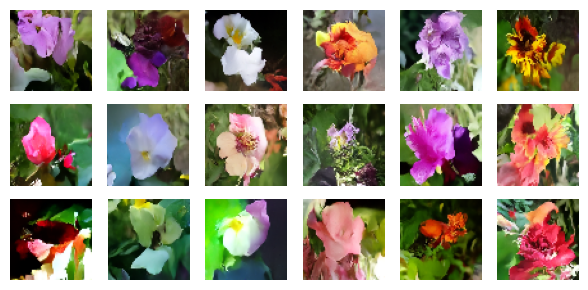

In [18]:
for images, labels, text_embedding in val_dataset.take(1):
    conditions = text_embedding  # Use the labels from the validation set as conditions
    plt.figure(figsize=(4, 4))
    image_to_plot = tf.convert_to_tensor(images[0])  # Convert tensor to NumPy-compatible format
    plt.imshow((image_to_plot * 255).numpy().astype('uint8'))  # Assuming `images` is normalized in the range [0, 1]
    plt.title("Input Image")
    plt.axis('off')
    plt.show()
    model.test_step((images, labels, text_embedding))
    model.plot_images(val_dataset=val_dataset)
    break  # Take only the first+-

# Inference

## Set up testing dataset

In [19]:
# File paths
caption_file_path = "/home/henry/HD/DL/DL_comp3/2024-datalab-cup3-reverse-image-caption/dataset/testData.pkl"
id2word_file_path = "/home/henry/HD/DL/DL_comp3/2024-datalab-cup3-reverse-image-caption/dictionary/id2Word.npy"

# Load the .pkl file
with open(caption_file_path, 'rb') as file:
    captions_data = pickle.load(file)

# Convert to DataFrame
captions_df = pd.DataFrame(captions_data)

# Load the id2Word mapping
data = np.load(id2word_file_path, allow_pickle=True)

# Convert array to dictionary
id2word = {int(row[0]): row[1] for row in data}

# Prepare captions and IDs
all_captions = []
all_ids = []

# Process each row to collect captions and IDs
for _, row in tqdm.tqdm(captions_df.iterrows(), total=captions_df.shape[0], desc="Preparing captions"):
    captions = row['Captions']
    id = row['ID']
    all_captions.append(captions)  # Append list of word IDs as a single caption
    all_ids.append(id)  # Append the corresponding ID

# Function to process text embeddings
def batch_text_embeddings(captions_batch):
    texts = [" ".join([id2word.get(int(word_id), "<UNK>") for word_id in caption]) for caption in captions_batch]
    text_inputs = tokenizer(texts, return_tensors="tf", padding=True, truncation=True)
    text_embeddings = clip_model.get_text_features(input_ids=text_inputs["input_ids"])
    # Normalize embeddings if required
    text_embeddings = tf.nn.l2_normalize(text_embeddings, axis=-1)
    return texts, text_embeddings

# Batched processing
BATCH_SIZE = 1024  # Adjust based on memory
image_text_pairs = []

for i in tqdm.tqdm(range(0, len(all_captions), BATCH_SIZE), desc="Processing batches"):
    batch_captions = all_captions[i:i + BATCH_SIZE]
    batch_ids = all_ids[i:i + BATCH_SIZE]
    texts, batch_embeddings = batch_text_embeddings(batch_captions)
    image_text_pairs.extend(zip(batch_ids, texts, batch_embeddings.numpy()))

# Create TensorFlow Dataset
dataset = tf.data.Dataset.from_generator(
    lambda: iter(image_text_pairs),
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.int32),           # ID
        tf.TensorSpec(shape=(), dtype=tf.string),          # Text
        tf.TensorSpec(shape=(768,), dtype=tf.float32)      # Text embeddings
    )
)

# Batch and prefetch the dataset
test_dataset = (
    dataset
    .batch(39, drop_remainder=False)  # Batch size of 39 as per your requirement
    .prefetch(tf.data.AUTOTUNE)       # Optimize data loading
)

# Preview the dataset
for id, text, text_embedding in test_dataset.take(2):
    print("ID:", id.numpy())
    print("Text Embedding Shape:", text_embedding.shape)
    print("Text:", [t.decode('utf-8') for t in text.numpy()])


Processing batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

ID: [6735 6740 6746 6759 6762 6765 5107 5108 5133 6623 6647 5655 5666 5682
 5147 5148 5175 5177 5181 5184 5187 5190 5198 7175 7184 7190 7192 7203
 7208 7219 7222 7225 7227 8101 3284 3296 3322 3323 3327]
Text Embedding Shape: (39, 768)
Text: ['this white and purple flower has fragile petals and soft stamens <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>', 'this flower has four large wide pink petals with white centers and vein like markings <PAD> <PAD> <PAD> <PAD> <PAD>', 'a flower with broad white and pink ribbed petals and yellow stamen <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>', 'one prominet pistil with alarger stigam and many stamens with anthers <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>', 'leaves are green in color petals are light pink in color <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>', 'this flower is bright pink with overlapping petals and a lime green pistil <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>', 'this flower is white and yellow in co

## Load Model from ckpt

In [135]:
model = ConditionalDiffusionModel(image_size, widths, block_depth, 768)

# Path to the saved checkpoint
checkpoint_path = f"checkpoints/DDIM/tf_checkpoint{20:03d}"

# Load the saved weights
model.load_weights(checkpoint_path)

In [136]:
batched_dataset = train_dataset.map(lambda x, y, z: x).prefetch(tf.data.AUTOTUNE)

# Adapt the normalization layer using the batched dataset
model.normalizer.adapt(batched_dataset)

In [185]:
if not os.path.exists('./inference'):
    os.makedirs('./inference')

import time
def inference(test_dataset, model, output_dir='./inference/demo', batch_size=32, num_epochs=1):
    """
    Perform inference on the test dataset and save generated images.

    Parameters:
    - test_dataset: tf.data.Dataset, the test dataset yielding (image, text, text_embedding).
    - model: A model instance with a generate method for image generation.
    - output_dir: str, path to save the generated images.
    - batch_size: int, number of samples per batch.
    - num_epochs: int, number of epochs to run inference.

    Saves:
    - Generated images as .jpg files in the output_dir.
    """
    step = 0
    start = time.time()
    
    for id, text, text_embedding in test_dataset:
        
        # Generate fake images using the provided model
        fake_images = model.generate(
            num_images=batch_size,
            conditions=text_embedding,
            diffusion_steps=60,
            guidance_scale=80.0
        )
        # print(tf.reduce_min(fake_images[0]).numpy(), tf.reduce_max(fake_images[0]).numpy())
        
        # Save each generated image
        for i in range(batch_size):
            file_path = os.path.join(output_dir, f'inference_{int(id[i]):04d}.jpg')
            img = (fake_images[i].numpy() * 255).astype('uint8')
            #img = Image.fromarray(img)
            img_resized = img#.resize((64, 64))
            plt.imsave(file_path, img_resized)
            step += 1


    print(f'Time for inference: {time.time() - start:.4f} seconds')

In [186]:
inference(test_dataset, model, output_dir='./inference', batch_size=39, num_epochs=1)

Time for inference: 73.5857 seconds


In [187]:
import os
import pandas as pd
import numpy as np

%cd testing
!python ./inception_score.py ../inference ../score.csv 39
%cd ..

score_file = './score.csv'
if os.path.exists(score_file):
    df_score = pd.read_csv(score_file)
    mean_score = np.mean(df_score['score'].values)
    print(f'Mean Score: {mean_score:f}')
else:
    print('Evaluation Failed!')

/mnt/sda/henry/DL/DL_comp3/2024-datalab-cup3-reverse-image-caption/testing
1 Physical GPUs, 1 Logical GPUs
--------------Evaluation Success-----------------
/mnt/sda/henry/DL/DL_comp3/2024-datalab-cup3-reverse-image-caption
Mean Score: 0.454854
